In [1]:
import numpy as np
import pandas as pd

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder, OrdinalEncoder, BinaryEncoder

from sklearn.preprocessing import FunctionTransformer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

%matplotlib inline
from matplotlib import style
style.use('ggplot')
style.use('seaborn-ticks')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # чтоб не ругался

Для использования PCA надо стандартизовать данные. Частично это было сделано в предыдущей работе. Возьмем тот же код, только хочется внести некоторые поправки. В прошлый раз я зачем-то поменял все unknownы на NA, это не очень правильно по отношению к фиче default, там их слишком много, примерно четверть.Кроме того, были стандартизованы не все признаки, поменяем MinMaxScaler на Standart, оставим Unknown в default как отдельную группу и датасет можно пробовать использовать для понижения размерности. Я не очень понимаю, можно ли так делать с преобразованными категориальными и порядковыми признаками, вообще, кажется, что это не очень правильно, но и распределение практически у всех признаков не является нормальным, поэтому попробуем сделать именно так.

In [2]:
df = pd.read_csv('bank.csv', delimiter = ';', na_values = 'unknown')
df['default'].fillna('unknown', inplace = True)
df.drop('pdays',axis = 1, inplace = True)

In [3]:
df['y'].replace({'yes':1, 'no':0}, inplace = True)

In [4]:
data_types = df.dtypes
int_cols = [df.columns[i] for i in range(df.shape[1]) if data_types[i] == 'int64']
float_cols = [df.columns[i] for i in range(df.shape[1]) if data_types[i] == 'float64']
cat_cols = [df.columns[i] for i in range(df.shape[1]) if data_types[i] == 'O']

In [5]:
mon_num = {'mar':1, 'apr':2, 'may':3, 'jun': 4, 'jul':5, 'aug':6, 'nov':7, 'sep':7, 'oct':8, 'nov':9, 'dec':10}
day_num = {day:i for day, i in zip(df['day_of_week'].unique(), range(1, 6))}
education_sorted = {'illiterate': 0, 'unknown': 1, 'basic.4y': 2,
                    'basic.6y': 3, 'basic.9y': 4, 'high.school': 5,
                    'professional.course': 6, 'university.degree': 7}

In [6]:
ord_mon = OrdinalEncoder(mapping=[{'col': 'month', 'mapping': mon_num}])
ord_day =  OrdinalEncoder(mapping=[{'col': 'day_of_week', 'mapping': day_num}])
ord_edu = OrdinalEncoder(mapping=[{'col': 'education', 'mapping': education_sorted}])

cat_steps = [('encoder', BinaryEncoder(drop_invariant = True)),
            ('imputer', KNNImputer(weights = 'distance')),
              ('scaler', StandardScaler())
             ]


In [7]:
transf = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

transformer = ColumnTransformer(
    [
    ('encode_scale', Pipeline(steps = cat_steps), list(set(cat_cols)-set(['day_of_week', 'month', 'y']))),
    ('month', Pipeline(steps = [('ord_mon', ord_mon) , ('scale_mon', StandardScaler())]), 'month'),
    ('day', Pipeline(steps = [('ord_day', ord_day), ('scale_day', StandardScaler())]), 'day_of_week'),
    ('scale', StandardScaler(), ['age', 'duration', *float_cols, 'previous', 'campaign'])
    ]
)
    

In [8]:
transformer.fit(df, df['y']);
data = transformer.transform(df);
pd.DataFrame(data).to_csv('data_scaled.csv', index = False)

## PCA

In [9]:
from sklearn.decomposition import PCA

X = data
Y = df['y']

pca = PCA()
PC = pca.fit_transform(X)

var_list = pca.explained_variance_ratio_.round(2)

In [10]:
cum = var_list.cumsum()
len(cum[cum < 0.95])+1

22

С помощью PCA удалось избавиться от 11 признаков с потерей 5% объясненной дисперсии. Но без учета кодировки неколичественных переменных признаков было 19. Это может быть из-за выбросов, попробуем их устранить.  
Воспользуемся методом LOF (Local Outlier Factor). Метод заключается в оценке плотности наблюдений по сравнению со своими соседями. Будем искать выбросы на числовых признаках.  

In [11]:
scaler = StandardScaler()
df_out = scaler.fit_transform(df[[*int_cols, *float_cols]])

In [12]:
from sklearn.neighbors import LocalOutlierFactor

In [13]:
lof = LocalOutlierFactor(n_neighbors= 20)
outliers_data = lof.fit_predict(df_out)
mask = outliers_data != -1

In [14]:
df1 = df[mask]
transformer.fit(df1, df['y']);
data1 = transformer.transform(df1);

X1 = data1

pca1 = PCA()
PC1 = pca1.fit_transform(X1)

var_list1 = pca1.explained_variance_ratio_.round(2)

In [15]:
cum = var_list.cumsum()
len(cum[cum <= 0.95])

21

In [16]:
(var_list == var_list1).all() # по-видимому дело не в выбросах

True

Ради интереса посмотрим, как PCA сработает только на числовых признаках

In [17]:
X_num = scaler.fit_transform(df1[[*int_cols, *float_cols]])

In [18]:
pca_num = PCA()
PC1 = pca_num.fit_transform(X_num)
var_list_num = pca_num.explained_variance_ratio_.round(2)

In [19]:
cum_num = var_list_num.cumsum()
len(cum_num[cum_num <= 0.95])

6

In [20]:
len(cum[cum <= 0.95])/len(var_list), len(cum_num[cum_num <= 0.95])/len(var_list_num) # PCA работает примерно одинаково 

(0.65625, 0.6)

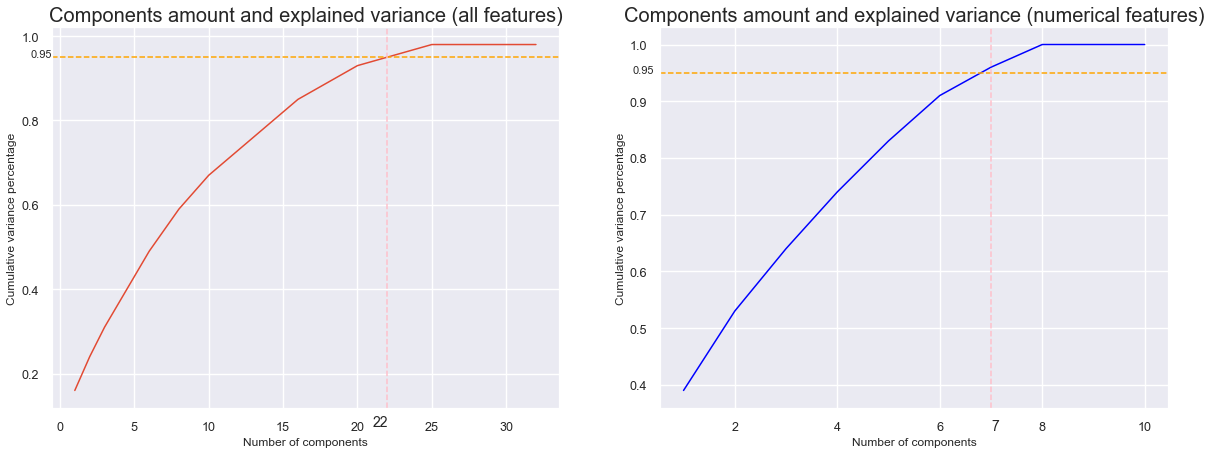

In [21]:
sns.set_style("darkgrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 7))
sns.lineplot(x = range(1, len(cum) + 1), y = cum, ax = ax1)
sns.lineplot(x = range(1, len(cum_num) + 1), y = cum_num, ax = ax2, color='blue')

ax1.set_title('Components amount and explained variance (all features)', fontsize=20)
ax2.set_title('Components amount and explained variance (numerical features)', fontsize=20)
ax1.axhline(0.95, ls='--', c = 'orange'), ax2.axhline(0.95, ls='--', c = 'orange')


ax1.text(-2, 0.95, '0.95', fontsize = 11), ax2.text(0, 0.95, '0.95', fontsize = 11)
ax1.axvline(x = len(cum[cum <= 0.95]) + 1, ls='--', c = 'pink'), ax2.axvline(x = len(cum_num[cum_num <= 0.95]) + 1, ls='--', c = 'pink')
ax1.text(len(cum[cum <= 0.95] + 1), 0.075, f'{len(cum[cum <= 0.95]) + 1}', fontsize = 14), ax2.text(len(cum_num[cum_num <= 0.95])+1, 0.32, f'{len(cum_num[cum_num <= 0.95]) + 1}', fontsize = 14)

        
ax1.set_ylabel('Cumulative variance percentage'), ax2.set_ylabel('Cumulative variance percentage')
ax1.set_xlabel('Number of components'), ax2.set_xlabel('Number of components');


Для всех признаков линия достаточно плавная, по аналогии с методом каменистой осыпи определить сложно, в случае числовых признаков линия имеет не слишком заметный излом при 6 компонентах